In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal, ndimage
from scipy.optimize import curve_fit

## Data reading

In [ ]:
pert_strength = 0.3
dir_name = 'T:/Team/Szewczyk/Data/2024-02-22/'

In [ ]:
current = pd.read_csv(dir_name+'example_period.csv')
prc = pd.read_csv(dir_name+'prc.csv')
prc['norm_response'] = prc.response/pert_strength

## PRC fitting

In [ ]:
def gaussian(x, h, m, s):
    d = np.minimum(np.abs(x-m), 1-np.abs(x-m))
    return h*np.exp(-d**2/(2*s))

def curve(x, h1, m1, s1, h2, m2, s2):
    return gaussian(x, h1, m1, s1) + gaussian(x, h2, m2, s2)

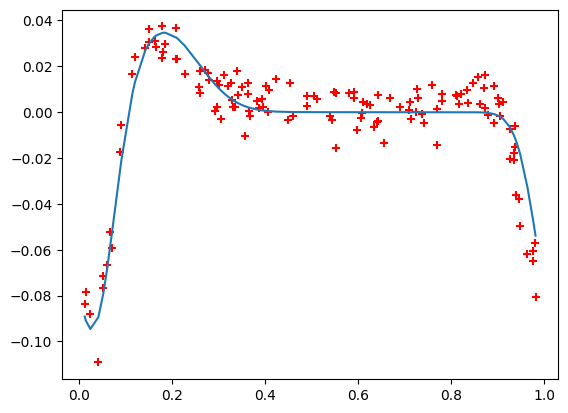

In [ ]:
initial_guess = (0.035, 0.18, 0.006, -0.1, 0.03, 0.002)
plt.figure()
plt.plot(prc.phase, curve(prc.phase, *initial_guess))
plt.scatter(prc.phase, prc.norm_response, marker='+', c='r')

In [ ]:
popt, popc = curve_fit(curve, prc.phase, prc.norm_response, initial_guess)

In [ ]:
def fitted_prc(x):
    return curve(x%1, *popt)

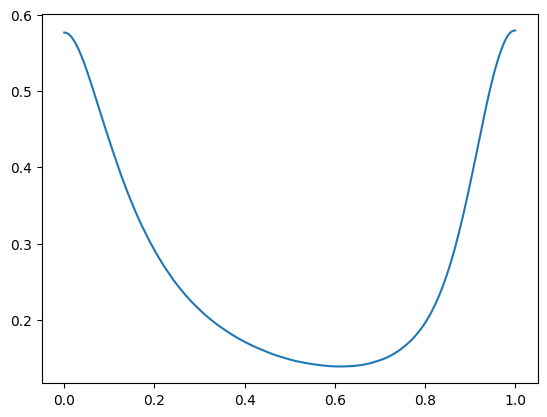

In [ ]:
plt.plot(current.phase, current.I)

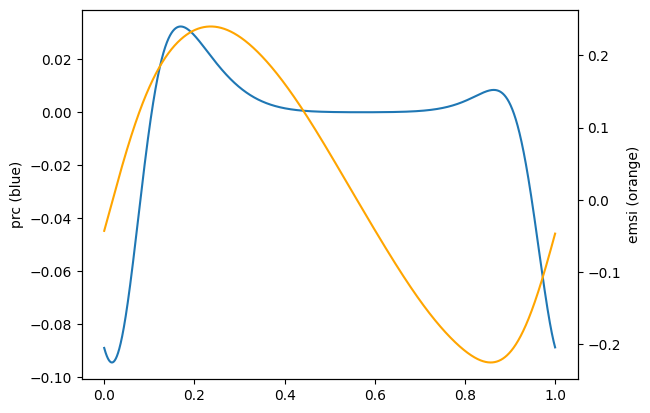

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(current.phase, fitted_prc(current.phase))
ax1.set_ylabel('prc (blue)')
ax2.plot(current.phase, current.emsi_corrected, c='orange')
ax2.set_ylabel('emsi (orange)')
plt.show()

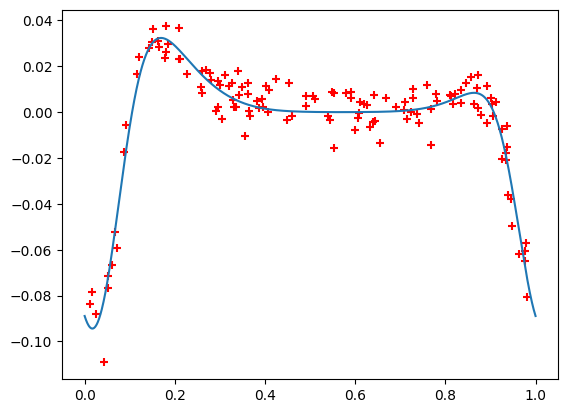

In [ ]:
plt.scatter(prc.phase, prc.norm_response, marker='+', c='r')
plt.plot(np.linspace(0, 1, 1000), curve(np.linspace(0, 1, 1000), *popt), zorder=10)

## Phase offset

In [ ]:
def rolled_I(delta_phi):
    return np.interp((current.phase+delta_phi)%1, current.phase, current.I)

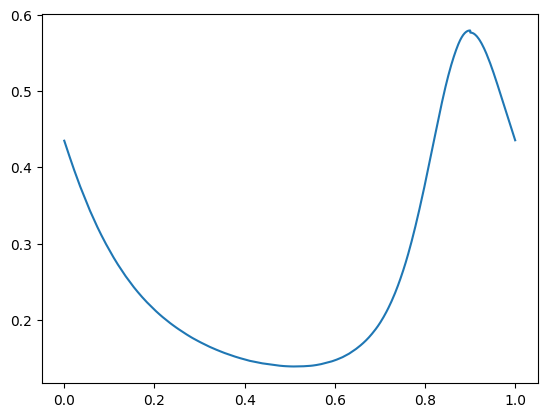

In [ ]:
plt.plot(current.phase, rolled_I(0.1))

When electrode 1 is ahead of electrode 2 by $\Delta\phi$, the potential pert. experienced by electrode 1 will be

$$j_2(\phi + \Delta\phi) - j_1(\phi)$$

Positive $\Delta \phi$ means that the electrode of interest is ahead.

## Calculating the interaction function

F is the integral:

$$\int_0^1 \mathrm{PRC}_1(\phi)[j_2(\phi+\Delta \phi) - j_1(\phi)] d\phi$$

In [ ]:
def F(delta_phi):
    return np.sum((rolled_I(delta_phi)-current.I)*fitted_prc(current.phase))/current.phase.size

In [ ]:
effect = np.empty_like(current.phase)
for i, delta_phi in enumerate(current.phase):
    effect[i] = F(delta_phi)*current.t.iloc[-1]

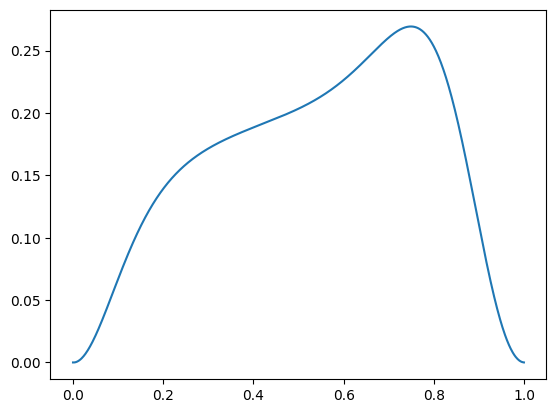

In [ ]:
plt.plot(current.phase, effect)

In [ ]:
effect_pd = pd.DataFrame({
    'delta_phi'     : current.phase,
    'effect'        : effect
})
effect_pd.to_csv('effect_LALA.csv')

We are interested in the odd part of the interaction function. If both electrodes are slowed down or sped up by the same amount, we don't see a change in their phase offset. Only the antisymmetric interaction will affect $\Delta \phi$.

Text(0.5, 0, '$\\Delta\\phi$')

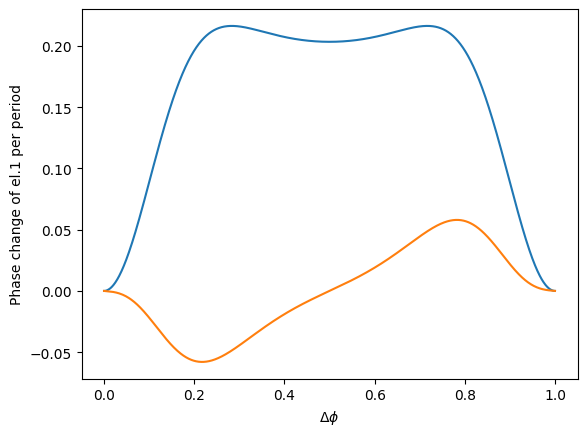

In [ ]:
plt.plot(current.phase, (effect + effect[::-1])/2)
plt.plot(current.phase, (effect - effect[::-1])/2)
plt.ylabel("Phase change of el.1 per period")
plt.xlabel(r"$\Delta\phi$")

The orange curve is predicting the relative phase change of electrode 1 after one period of being coupled with electrode 2. We see that for positive $\Delta \phi$, which means el.1 is ahead, results a negative phase response (slowing down) of el.1, which in turn syncs both electrodes.